In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain.embeddings.base import Embeddings

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, BaseMessage

from langgraph.graph.message import add_messages
from sentence_transformers import SentenceTransformer
from langchain_core.tools import tool

a:\AI_Projects\AI Conversational Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pdf_loaded = PyPDFLoader(file_path='A:\AI_Projects\AI Conversational Agent\ml_pdf_for_rag.pdf')
docs = pdf_loaded.load()
print(f"total pages: {len(docs)}")

total pages: 85


In [3]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=300)
chunks = splitter.split_documents(docs)

In [ ]:
# Create custom embeddings class
class SentenceTransformerEmbeddings(Embeddings):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
    
    def embed_documents(self, texts):
        return self.model.encode(texts).tolist()
    
    def embed_query(self, text):
        return self.model.encode([text])[0].tolist()

# Initialize embeddings
embeddings = SentenceTransformerEmbeddings()

# Assuming you have your chunks
# chunks = your existing chunks from RecursiveCharacterTextSplitter

print(f"Creating FAISS vector store from {len(chunks)} chunks...")

# Create FAISS vector store
vectorstore = FAISS.from_documents(chunks, embeddings)

# Save to disk
vectorstore.save_local("faiss_index")

print("FAISS vector store saved to 'faiss_index' folder!")

Creating FAISS vector store from 215 chunks...
FAISS vector store saved to 'faiss_index' folder!


In [8]:
retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 4})

In [9]:
ret = retriever.invoke('what is machine learning')
print(len([re.page_content for re in ret]))
[re.page_content for re in ret]

4


['7\nWhat is Machine Learning?\nMachine learning is a branch of computer science that allows computers \nto automatically infer patterns from data without being explicitly told what \nthese patterns are. These inferences are often based on using algorithms \nto automatically examine the statistical properties of the data and creating \nmathematical models to represent the relationship between different quantities.\nLet’s contrast this with traditional computing, which relies on deterministic  \nsystems, wherein we explicitly tell the computer a set of rules to perform a \nspecific task. This method of programming computers is referred to as being \nrules-based. Where machine learning differs from and supersedes, rules-based \nprogramming is that it’s capable of inferring these rules on its own.\nSay you’re a bank manager, and you’d like to figure out whether a loan applicant \nis likely to default on their loan. In a rules-based approach, the bank manager (or',
 'the applicant default 

In [ ]:
@tool
def rag_tool(query: str):
    """
    Reterieved relevent information from the pdf documents.
    use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents
    """

    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [39]:
tools = [rag_tool]

load_dotenv()
from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite', temperature=0.7)
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.7)

llm_binded = llm.bind_tools(tools)

In [40]:
class state_class(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [41]:
def chat_node(state: state_class):
    message = state['messages']
    response = llm_binded.invoke(message)
    return {'messages': [response]}

In [42]:
tool_node = ToolNode(tools)

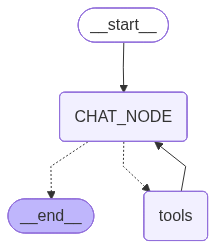

In [43]:
graph = StateGraph(state_class)

graph.add_node('CHAT_NODE', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'CHAT_NODE')
graph.add_conditional_edges('CHAT_NODE', tools_condition)
graph.add_edge('tools', 'CHAT_NODE')

chatbot = graph.compile()
chatbot

In [46]:
result = chatbot.invoke(
    {
        'messages':[
            HumanMessage(
                content=(
                    'using the pdf tool, explain machine learning in short'
		    )
		)
	  ]
    }
)

In [49]:
# Analyze the result structure
print("=== RESULT ANALYSIS ===")
print(f"Number of messages: {len(result['messages'])}")
print(f"\nLast message type: {type(result['messages'][-1])}")

# Check if there are tool calls
for i, msg in enumerate(result['messages']):
    print(f"\n--- Message {i}: {type(msg).__name__} ---")
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"Tool calls detected: {len(msg.tool_calls)}")
        for tc in msg.tool_calls:
            print(f"  Tool name: {tc.get('name') if isinstance(tc, dict) else tc.name}")
    if hasattr(msg, 'content'):
        content_str = str(msg.content)
        print(f"Content: {content_str[:200]}..." if len(content_str) > 200 else f"Content: {content_str}")

print("\n=== CONCLUSION ===")
print("The output shows a multi-turn conversation where:")
print("1. Message 0: User request (HumanMessage)")
print("2. Message 1: LLM detected user wants to use the PDF tool (AIMessage with tool_calls)")
print("3. Message 2: Tool execution result (ToolMessage)")
print("4. Message 3: Final LLM response using tool context (AIMessage)")

=== RESULT ANALYSIS ===
Number of messages: 4

Last message type: <class 'langchain_core.messages.ai.AIMessage'>

--- Message 0: HumanMessage ---
Content: using the pdf tool, explain machine learning in short

--- Message 1: AIMessage ---
Tool calls detected: 1
  Tool name: rag_tool
Content: 

--- Message 2: ToolMessage ---
Content: {"query": "machine learning definition", "context": ["the applicant default or not, is this a picture of a cat, a dog, or a human, etc. — \nthen the problem is referred to as classification, as we’re ...

--- Message 3: AIMessage ---
Content: Machine learning is a branch of computer science that allows computers to automatically infer patterns from data without being explicitly told what these patterns are. It is a type of artificial intel...

=== CONCLUSION ===
The output shows a multi-turn conversation where:
1. Message 0: User request (HumanMessage)
2. Message 1: LLM detected user wants to use the PDF tool (AIMessage with tool_calls)
3. Message 2: Tool e